# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: TC5035.10 Proyecto Integrador**
### Tecnológico de Monterrey
### Dra. Grettel Barceló Alonso 
### Dr. Luis Eduardo Falcón Morales

## **Avance 2. Ingeniería de características**


**Nombres y matrículas de los integrantes del equipo:**
| Nombre | Matrícula |
| --- | --- |
| Rodrigo López Aguilera | A01793071 |
| Alejandra Mendoza Flores | A01793032 |
| Diego Carrera Nicholls | A00464290 |

In [206]:
# "python.dataScience.enablePlotViewer": false
# disable plot viewer
%matplotlib inline

In [207]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from scipy.stats import boxcox

import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.encoding import MeanEncoder

from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler, RobustScaler, \
    FunctionTransformer
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("whitegrid")


In [208]:
pd.options.display.float_format = '{:,.2f}'.format

In [209]:
def plot_boxplot_and_hist(data, variable):
    #figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True,
        gridspec_kw={"height_ratios": (0.50, 0.85)}
    )

    # assigning a graph to each ax
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.title(variable)
    plt.show()

In [210]:
def diagnostic_plots(df):
  # for every column in the dataframe, plot a histogram and a Q-Q plot of the data, on a nx2 grid

  # get the number of columns
  n_columns = df.shape[1]

  # create a figure with a grid of n_columns x 2
  fig, ax = plt.subplots(n_columns, 2, figsize=(15, 3*n_columns))

  # for every column, plot a histogram and a Q-Q plot
  for i, col in enumerate(df.columns):
    # plot histogram
    df[col].plot.hist(bins=50, ax=ax[i, 0])
    ax[i, 0].set_title(f'{col} histogram')

    # plot Q-Q plot
    stats.probplot(df[col], dist="norm", plot=ax[i, 1])
    ax[i, 1].set_title(f'{col} Q-Q plot')

  plt.tight_layout()
  plt.show()

In [211]:
def make_qqplot(df):
    # qq-plot of every column arranged on a grid
    n_columns = 4
    n_rows = int(np.ceil(df.shape[1] / n_columns))

    fig, ax = plt.subplots(n_rows, n_columns, figsize=(20, 4*n_rows))

    for i, col in enumerate(df.columns):
        stats.probplot(df[col], dist="norm", plot=ax[i//n_columns, i%n_columns])
        ax[i//n_columns, i%n_columns].set_title(col)

    plt.tight_layout()
    plt.show()



In [212]:
def plot_discrete_bins(variables, train, test):

  cols = 3
  rows = int(np.ceil(len(variables) / cols))

  fig, ax = plt.subplots(rows, cols, figsize=(15, 20))

  for i, var in enumerate(variables):

    plt.subplot(rows, cols, i+1)
     # determine proportion of observations per bin
    t1 = train[var].value_counts(normalize=True)
    t2 = test[var].value_counts(normalize=True)

    # concatenate proportions
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']

    # sort the intervals
    tmp.sort_index(inplace=True)

    # plot the bar plot
    tmp.plot.bar(ax=ax[i//cols, i%cols], grid=True)
    plt.xticks(rotation=45, fontsize=6)

  plt.tight_layout()
  plt.show()

In [213]:
df = pd.read_csv('data/pickwin-active-users.csv')

Los datos presentados en las entregas anteriores fueron generados a partir de los siguientes datos mostrados a continuación.

| Columna | Descripción |
| --- | --- |
| purchases_count | número de compras |
| purchases_amount | monto total de compras |
| cashouts_count | número de retiros |
| cashouts_amount | monto total de retiros |
| total_bets | número total de apuestas |
| winning_bets | número de apuestas ganadas |
| losing_bets | número de apuestas perdidas |
| total_risk | monto total apostado |
| total_win | monto total ganado |
| net_win | total_win - total_risk ganancia neta |
| days_since_last_bet | días desde la última apuesta |

*churned* se calcula a partir de la fecha de última actividad del usuario, si esta es mayor a 30 días, se considera que el usuario ha abandonado la plataforma.

*days_since_last* bet se retira de la lista de características porque sabemos de antemano que es una característica que dominará el modelo y además es una característica que se puede inferir haciendo una consulta en la base de datos.

De igual forma se eliminan la característica original de activity_ratio, que de igual forma dominará el modelo y es una característica que se puede inferir haciendo una consulta en la base de datos.


In [214]:
# drop days_since_registation
df = df.drop(columns=['days_since_registration'])

In [215]:
df.head()

,purchases_count,purchases_amount,cashouts_count,cashouts_amount,total_bets,winning_bets,losing_bets,total_risk,total_win,net_win,churned
0,1,300.00,0,0.00,1.00,0.00,1.00,300.00,0.00,-300.00,1
1,1,25.00,0,0.00,2.00,0.00,2.00,30.00,0.00,-30.00,1
2,1,200.00,0,0.00,14.00,12.00,1.00,200.00,0.00,-200.00,0
3,1,500.00,0,0.00,1.00,0.00,1.00,500.00,0.00,-500.00,1
4,3,250.00,0,0.00,9.00,1.00,8.00,320.00,19.39,-300.61,1


Revisión de valores nulos y duplicados

In [216]:
df.isnull().sum()

purchases_count       0
purchases_amount      0
cashouts_count        0
cashouts_amount       0
total_bets          501
winning_bets        501
losing_bets         501
total_risk          501
total_win           507
net_win             507
churned               0
dtype: int64

In [217]:
df = df.dropna()

In [218]:
df.duplicated().sum()

5599

In [219]:
df = df.drop_duplicates()

Eliminacion de filas que contengan todos sus valores en 0

In [220]:
# remove all rows with zero values in all columns
df = df[(df.T != 0).any()]

Vamos a generar características adicionales que puedan ser útiles para el modelo.

Ganancias Netas o *net_winnings* que indicará el monto neto ganado por el usuario, es decir, la diferencia entre el monto total ganado y el monto total apostado siempre y cuando el valor sea positivo, si el valor es negativo se tomará como 0.

Perdidas Netas o *net_losses* que indicará el monto neto perdido por el usuario, es decir, la diferencia entre el monto total ganado y el monto total apostado siempre y cuando el valor sea negativo, si el valor es positivo se tomará como 0.

Generamos una variable categórica *winner* que nos indique si el usuario es un ganador o perdedor, es decir, si el usuario tiene ganancias netas positivas o negativas.

In [221]:
df['net_winnings'] = df.apply(lambda x: x['net_win'] if x['net_win'] > 0 else 0, axis=1)
df['net_losses'] = df.apply(lambda x: x['net_win'] if x['net_win'] < 0 else 0, axis=1).abs()
df['winner'] = np.where(df['net_win'] > 0, 1, 0)


A continuación generamos un nuevo conjunto de datos que indiquen las relaciones entre variables

| Columna | Descripción |
| --- | --- |
| win_ratio | winning_bets / total_bets que nos indicará el porcentaje de apuestas ganadas |
| risk_per_bet | total_risk / total_bets que nos indicará el monto promedio apostado por apuesta |
| net_winnings_per_bet | net_winnings / total_bets que nos indicará el monto promedio ganado por apuesta |
| net_losses_per_bet | net_losses / total_bets que nos indicará el monto promedio perdido por apuesta |


In [222]:
# relation of winning bets to total bets
df['win_ratio'] = df['winning_bets'] / df['total_bets']

# relation of risked money to total bets
df['risk_per_bet'] = df['total_risk'] / df['total_bets']

# relation of net winnings to total bets
df['net_winnings_per_bet'] = df['net_winnings'] / df['total_bets']

# relation of net losses to total bets
df['net_losses_per_bet'] = df['net_losses'] / df['total_bets']



In [223]:
df.head()

,purchases_count,purchases_amount,cashouts_count,cashouts_amount,total_bets,winning_bets,losing_bets,total_risk,total_win,net_win,churned,net_winnings,net_losses,winner,win_ratio,risk_per_bet,net_winnings_per_bet,net_losses_per_bet
0,1,300.00,0,0.00,1.00,0.00,1.00,300.00,0.00,-300.00,1,0.00,300.00,0,0.00,300.00,0.00,300.00
1,1,25.00,0,0.00,2.00,0.00,2.00,30.00,0.00,-30.00,1,0.00,30.00,0,0.00,15.00,0.00,15.00
2,1,200.00,0,0.00,14.00,12.00,1.00,200.00,0.00,-200.00,0,0.00,200.00,0,0.86,14.29,0.00,14.29
3,1,500.00,0,0.00,1.00,0.00,1.00,500.00,0.00,-500.00,1,0.00,500.00,0,0.00,500.00,0.00,500.00
4,3,250.00,0,0.00,9.00,1.00,8.00,320.00,19.39,-300.61,1,0.00,300.61,0,0.11,35.56,0.00,33.40


In [224]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
purchases_count,"18,099.00",8.88,44.62,1.00,1.00,2.00,4.00,"2,221.00"
purchases_amount,"18,099.00","6,736.74","130,923.72",10.00,100.00,300.00,"1,000.00","12,664,286.00"
cashouts_count,"18,099.00",1.22,6.50,0.00,0.00,0.00,1.00,228.00
cashouts_amount,"18,099.00","5,222.71","92,331.58",0.00,0.00,0.00,400.00,"8,297,350.00"
total_bets,"18,099.00",81.22,760.46,1.00,5.00,13.00,34.00,"67,543.00"
winning_bets,"18,099.00",20.31,210.64,0.00,1.00,2.00,7.00,"17,863.00"
losing_bets,"18,099.00",60.81,565.37,0.00,4.00,10.00,26.00,"49,680.00"
total_risk,"18,099.00","36,671.22","892,191.11",0.00,290.00,760.00,"2,575.00","65,245,852.00"
total_win,"18,099.00","34,961.54","853,467.84",0.00,38.75,323.31,"1,911.00","63,361,273.78"
net_win,"18,099.00","-1,709.69","52,607.06","-4,606,897.53",-705.00,-245.00,-51.31,"1,351,780.57"


### Histogramas de las características

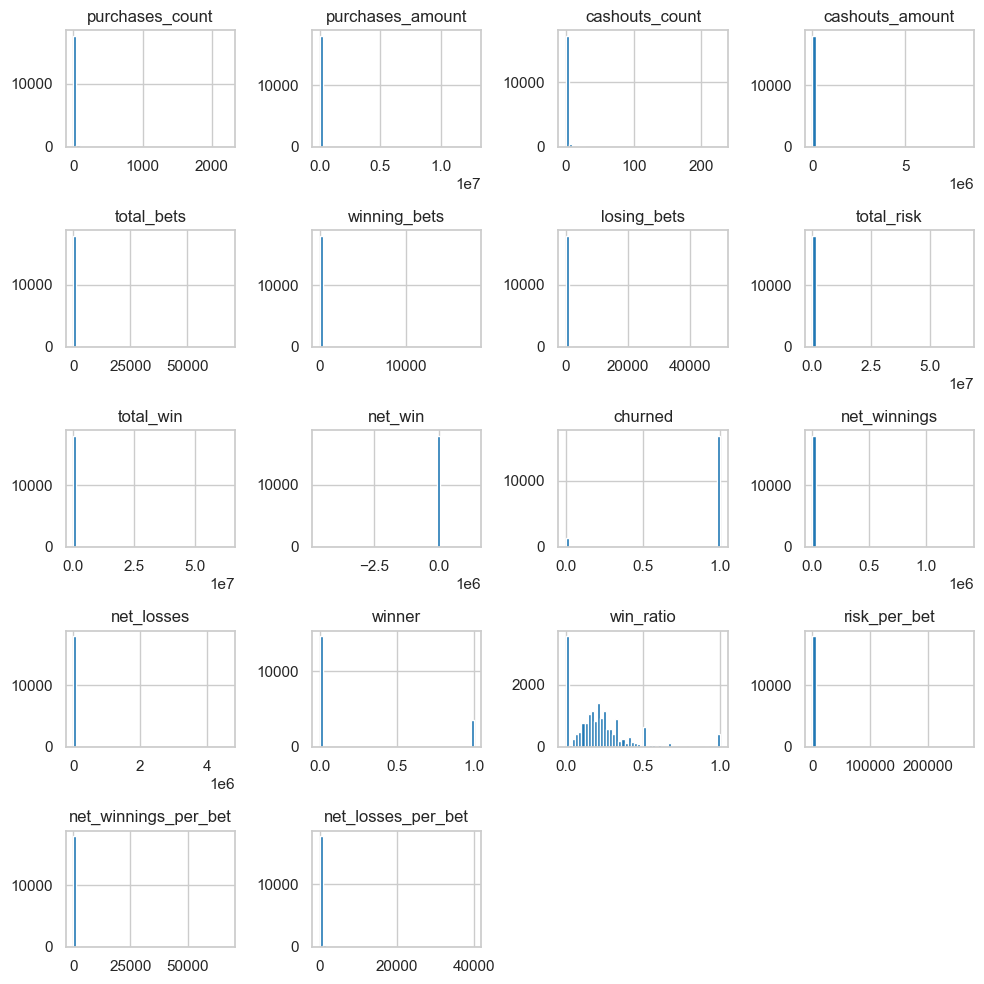

In [225]:
df.hist(bins=50, figsize=(10, 10))
plt.tight_layout()
plt.show()

### Boxplots de las características

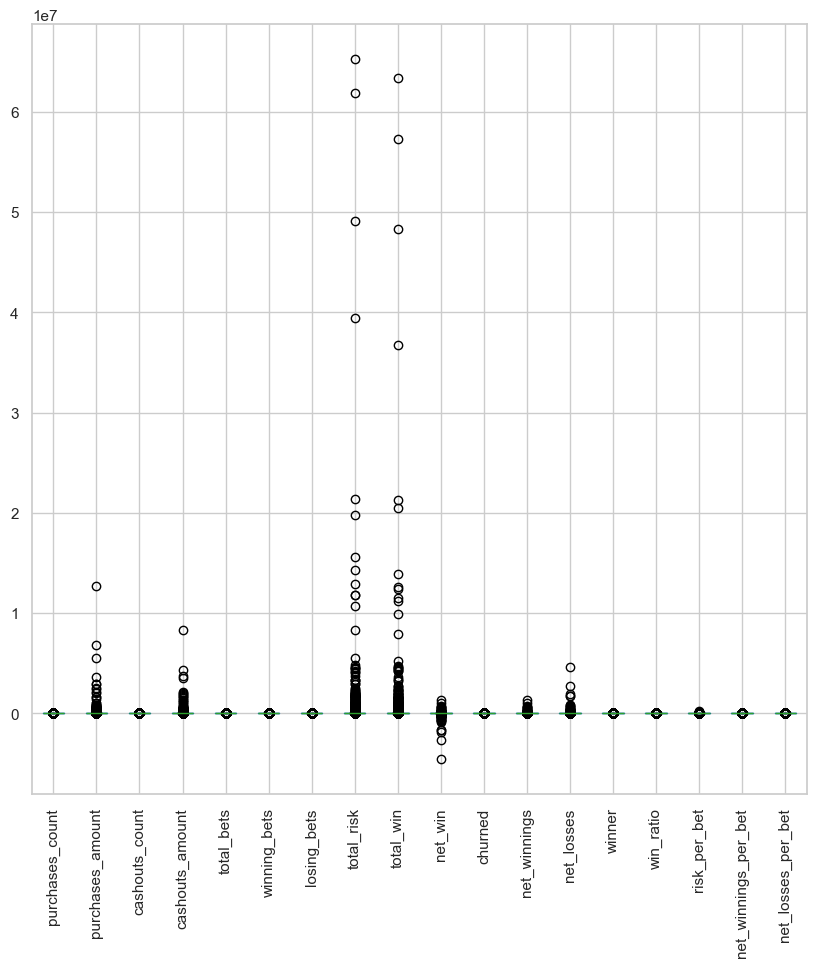

In [226]:
df.boxplot(figsize=(10, 10), rot=90)
plt.show()

De los histogramas y boxplots generados, se observa que las características tienen una distribución asimétrica y muchos valores atípicos por lo que exploraremos cuales son las posibles transformaciones y normalizaciones que podemos aplicar a las características.

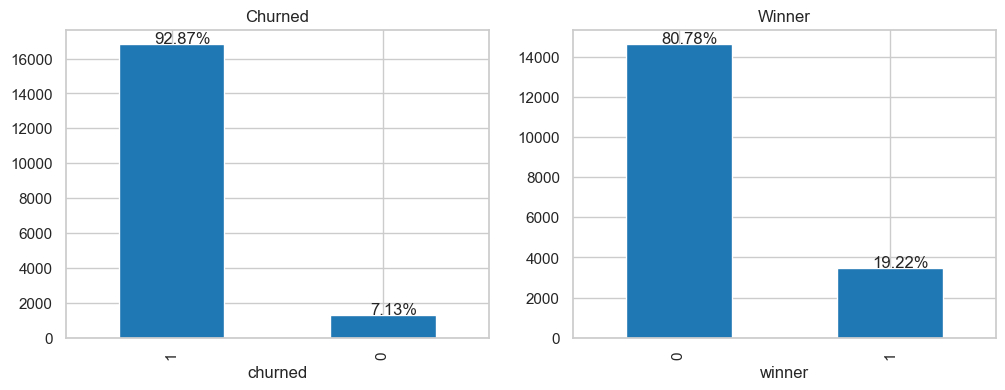

In [227]:
# plot of value counts for [churned, winner]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# plot subtitle
ax[0].set_title('Churned')
ax[1].set_title('Winner')

df['churned'].value_counts().plot(kind='bar', ax=ax[0])
# annotate the plot with the percentage of each category
for i in ax[0].patches:
    ax[0].text(i.get_x() + 0.3, i.get_height() + 50, f'{i.get_height()/df.shape[0]:.2%}', ha='center')

df['winner'].value_counts().plot(kind='bar', ax=ax[1])
# annotate the plot with the percentage of each category
for i in ax[1].patches:
    ax[1].text(i.get_x() + 0.3, i.get_height() + 50, f'{i.get_height()/df.shape[0]:.2%}', ha='center')

plt.show()


De igual forma podemos ver que la variable target *churned* no esta balanceada y en siguientes entregas exploraremos las posibles soluciones para balancearla.

### Explorando la perdida de información al realizar la eliminación de valores atípicos.

En la variable win_ratio eliminaremos de manera arbitraria los valores atípicos que se encuentren por encima del percentil 99 y por debajo del percentil 1.

In [228]:
churned_value_counts = df['churned'].value_counts()
churned_value_counts

churned
1    16809
0     1290
Name: count, dtype: int64

In [229]:
win_ratio_low = df['win_ratio'].quantile(0.01)
win_ratio_high = df['win_ratio'].quantile(0.99)

win_ratio_low, win_ratio_high

(0.0, 1.0)

In [230]:
filtered_churned_value_counts = df[(df['win_ratio'] > win_ratio_low) & (df['win_ratio'] < win_ratio_high)]['churned'].value_counts()
filtered_churned_value_counts

churned
1    12941
0     1182
Name: count, dtype: int64

In [231]:
# calculemos la perdida de información en la variable churned
( 1 - filtered_churned_value_counts / churned_value_counts ) * 100




churned
1   23.01
0    8.37
Name: count, dtype: float64

In [232]:
purchases_amount_low = df['purchases_amount'].quantile(0.01)
purchases_amount_high = df['purchases_amount'].quantile(0.99)

purchases_amount_low, purchases_amount_high

(25.0, 75499.12000000011)

In [233]:
filtered_purchases_amount_value_counts = df[(df['purchases_amount'] > purchases_amount_low) & (df['purchases_amount'] < purchases_amount_high)]['churned'].value_counts()
filtered_purchases_amount_value_counts

churned
1    16354
0     1203
Name: count, dtype: int64

In [234]:
( 1 - filtered_purchases_amount_value_counts / churned_value_counts ) * 100


churned
1   2.71
0   6.74
Name: count, dtype: float64

*Al eliminar los valores atípicos, se pierde entre el 8% y 9% de la clase minoritaria. y entre el 40% y 2% de la clase mayoritaria.*

No queremos perder información de la clase minoritaria, por lo que exploraremos otras técnicas para manejar los valores atípicos.

# Exploración de transformaciones y normalizaciones

In [235]:
# columns_to_transform = df.columns.drop(['churned', 'winner', 'days_since_registration', 'net_win']).tolist()
columns_to_transform = df.columns.drop(['churned', 'winner', 'net_win']).tolist()
print(columns_to_transform)

df_to_scale = df.copy()

['purchases_count', 'purchases_amount', 'cashouts_count', 'cashouts_amount', 'total_bets', 'winning_bets', 'losing_bets', 'total_risk', 'total_win', 'net_winnings', 'net_losses', 'win_ratio', 'risk_per_bet', 'net_winnings_per_bet', 'net_losses_per_bet']


In [236]:
robust_scaler = RobustScaler()
df_to_scale[columns_to_transform] = robust_scaler.fit_transform(df_to_scale[columns_to_transform])

In [237]:
df_to_scale[columns_to_transform] = df_to_scale[columns_to_transform].apply(lambda x: boxcox(x + 1)[0])

In [238]:
# other_columns = ['days_since_registration', 'net_win']
other_columns = ['net_win']

In [239]:
power_transformer = PowerTransformer()
df_to_scale[other_columns] = power_transformer.fit_transform(df_to_scale[other_columns])

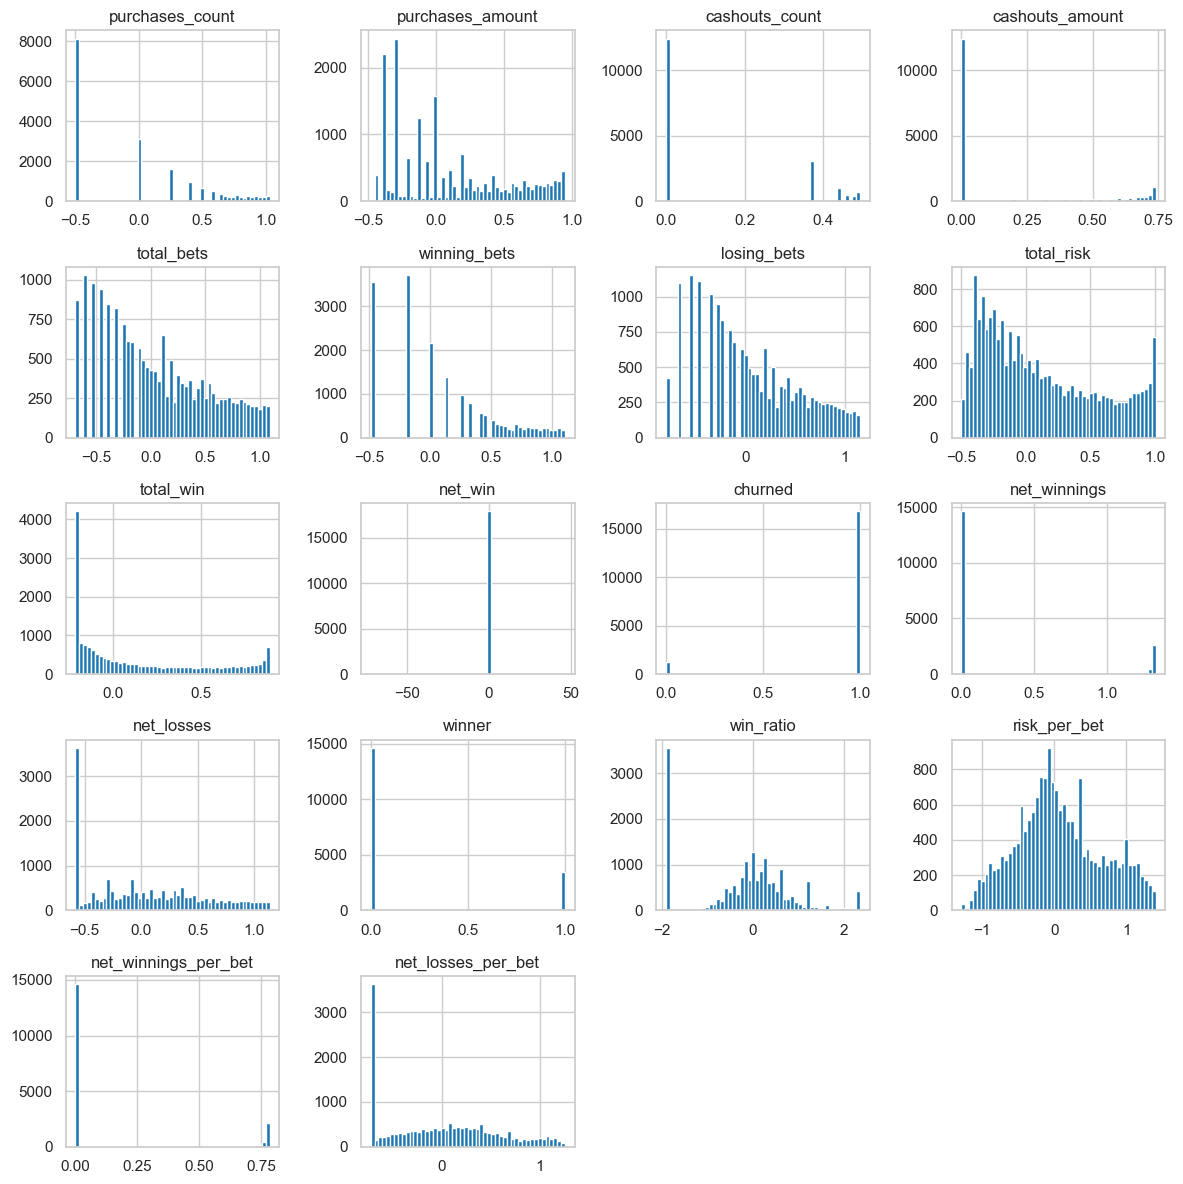

In [240]:
df_to_scale.hist(bins=50, figsize=(12, 12))
plt.tight_layout()
plt.show()

In [241]:
df_to_scale.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
purchases_count,"18,099.00",-0.00,0.51,-0.50,-0.50,0.00,0.40,1.03
purchases_amount,"18,099.00",0.10,0.42,-0.48,-0.29,0.00,0.43,0.95
cashouts_count,"18,099.00",0.13,0.19,0.00,0.00,0.00,0.37,0.49
cashouts_amount,"18,099.00",0.18,0.28,0.00,0.00,0.00,0.45,0.74
total_bets,"18,099.00",0.05,0.49,-0.69,-0.38,0.00,0.43,1.09
winning_bets,"18,099.00",0.12,0.47,-0.49,-0.20,0.00,0.47,1.11
losing_bets,"18,099.00",0.06,0.50,-0.80,-0.37,0.00,0.44,1.16
total_risk,"18,099.00",0.11,0.44,-0.50,-0.26,0.00,0.44,1.00
total_win,"18,099.00",0.15,0.37,-0.21,-0.18,0.00,0.44,0.89
net_win,"18,099.00",0.00,1.00,-71.94,-0.00,0.01,0.01,46.45


# Análisis de las transformaciones en bins (discretización)

In [242]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.model_selection import train_test_split

In [243]:
X, y = df.drop(['churned'], axis=1), df['churned']
X.shape, y.shape


((18099, 17), (18099,))

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [245]:
# variables a discretizar
variables = df.columns.drop(['churned', 'winner']).tolist()
eqf_d = EqualFrequencyDiscretiser(q=20, variables=variables, return_boundaries=True)

In [246]:
eqf_d.fit(X_train)

EqualFrequencyDiscretiser(q=20, return_boundaries=True,
                          variables=['purchases_count', 'purchases_amount',
                                     'cashouts_count', 'cashouts_amount',
                                     'total_bets', 'winning_bets',
                                     'losing_bets', 'total_risk', 'total_win',
                                     'net_win', 'net_winnings', 'net_losses',
                                     'win_ratio', 'risk_per_bet',
                                     'net_winnings_per_bet',
                                     'net_losses_per_bet'])

In [247]:
train_tf = eqf_d.transform(X_train)
test_tf = eqf_d.transform(X_test)

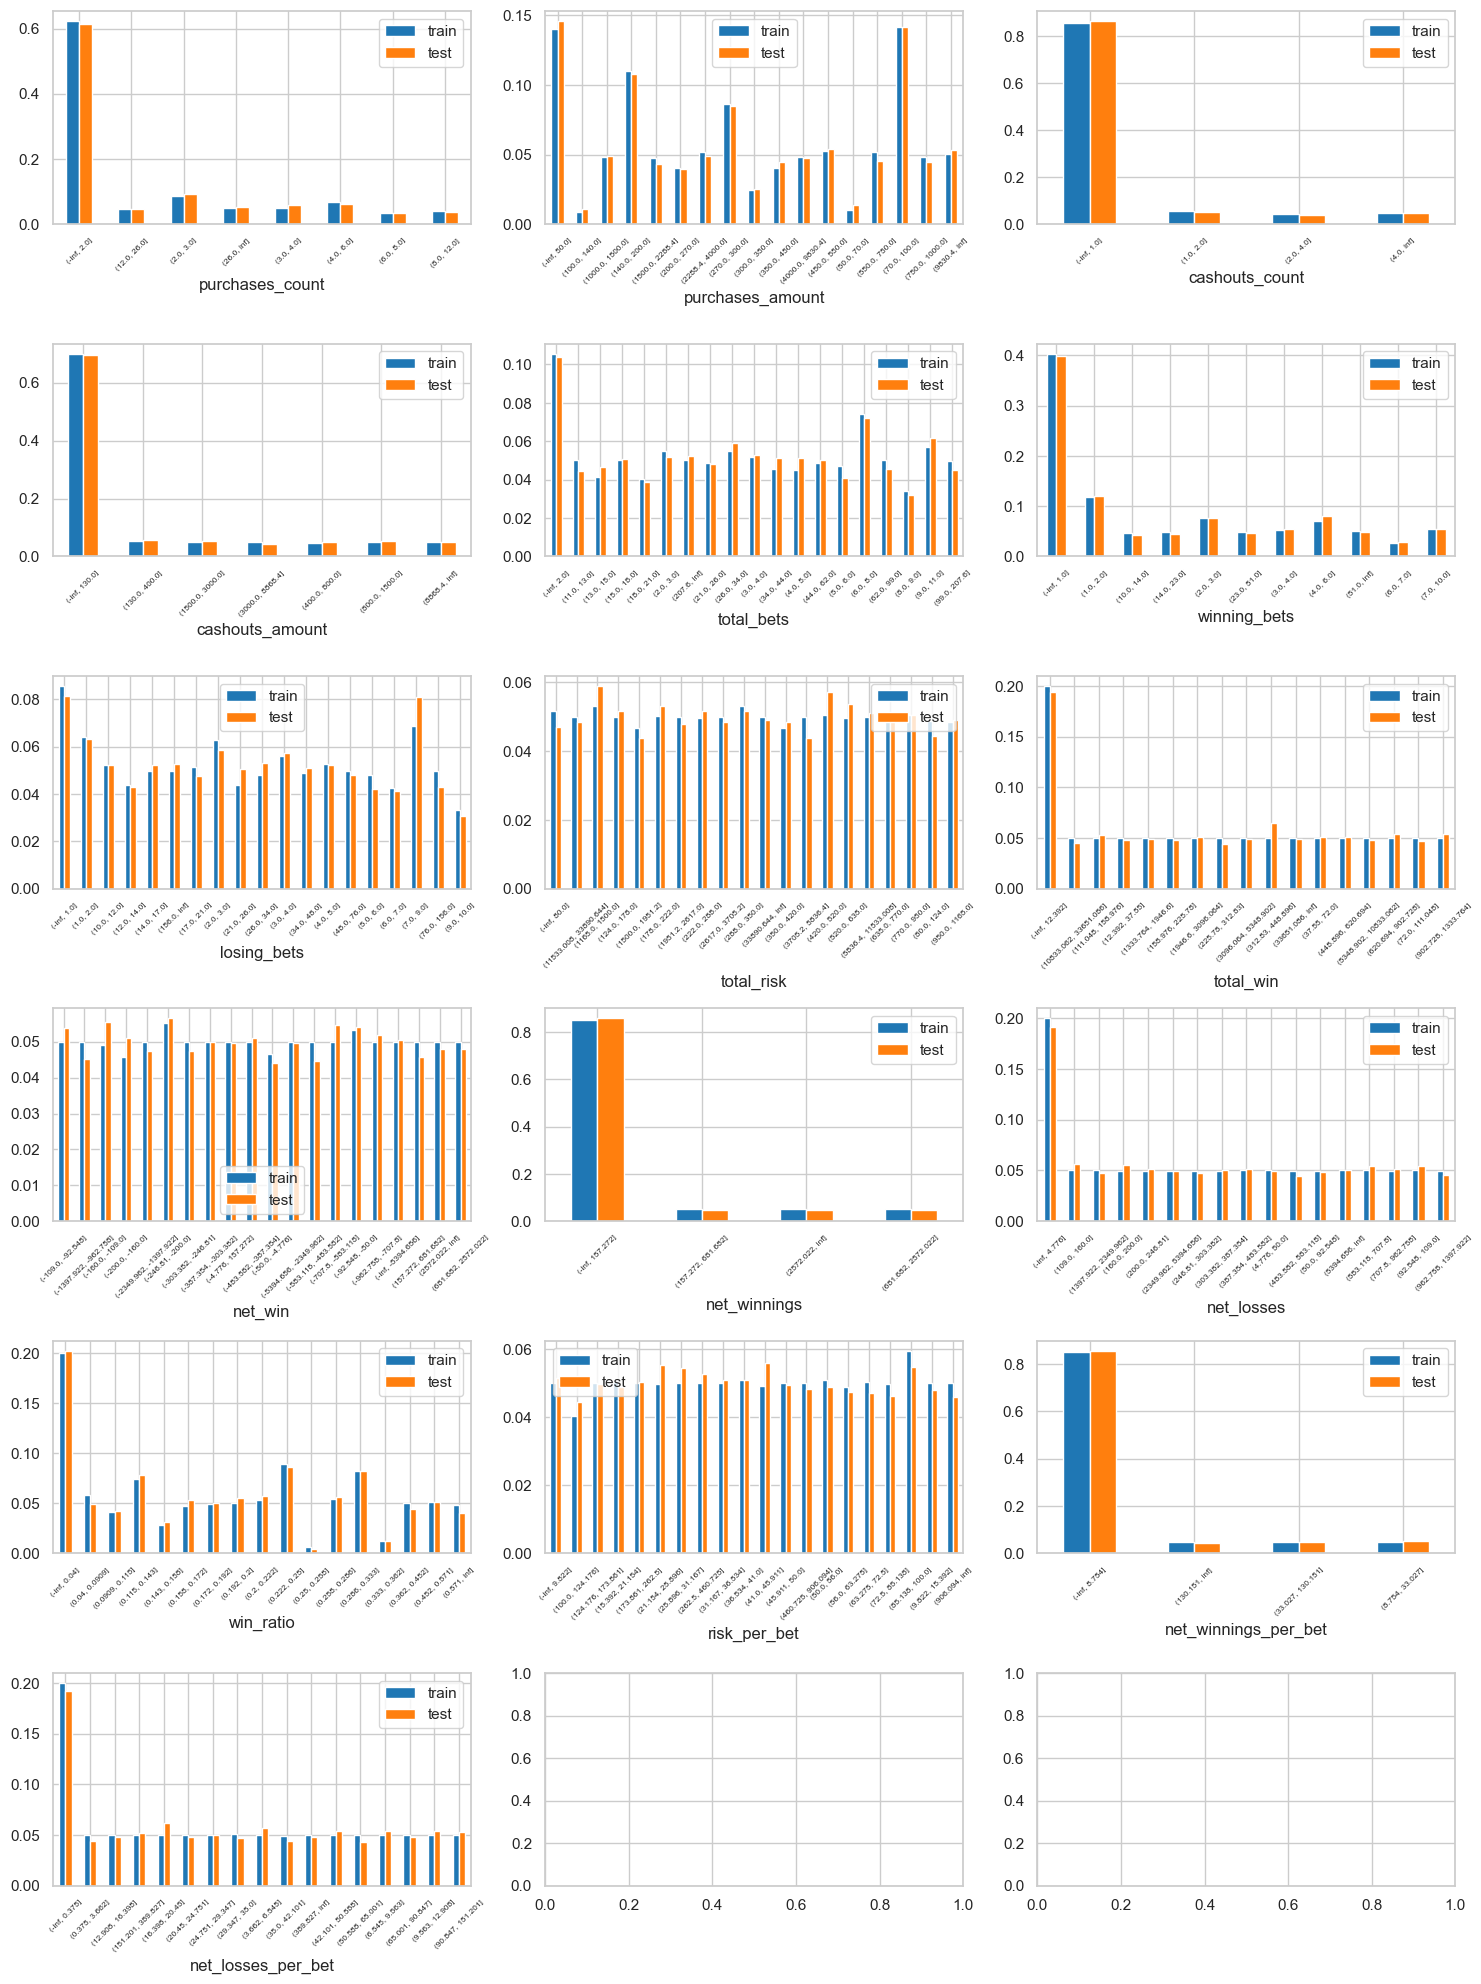

In [248]:
plot_discrete_bins(variables, train_tf, test_tf)

Creemos que la discretización de variables con 20 bins es una buena idea para poder manejar los valores atípicos y para poder manejar la distribución asimétrica de las características.

In [249]:
newDf = df[['net_winnings', 'cashouts_amount']]
newDf.describe()


,net_winnings,cashouts_amount
count,"18,099.00","18,099.00"
mean,"1,243.72","5,222.71"
std,"18,368.20","92,331.58"
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,400.00
max,"1,351,780.57","8,297,350.00"


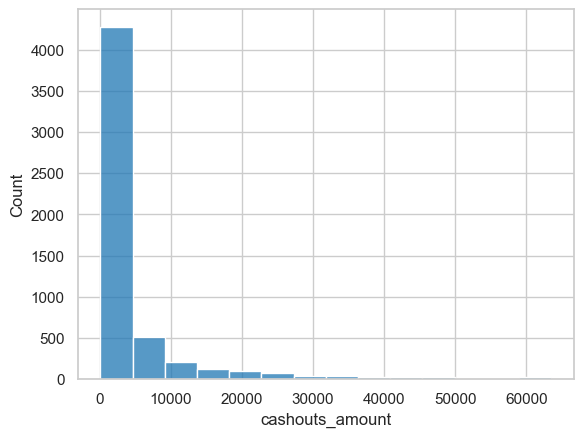

In [250]:

cashouts_amount_low = newDf['cashouts_amount'].quantile(0.01)
cashouts_amount_high = newDf['cashouts_amount'].quantile(0.99)


sns.histplot(data=newDf[(newDf['cashouts_amount'] > cashouts_amount_low) & (newDf['cashouts_amount'] < cashouts_amount_high)], x='cashouts_amount', bins="sturges")
plt.show()


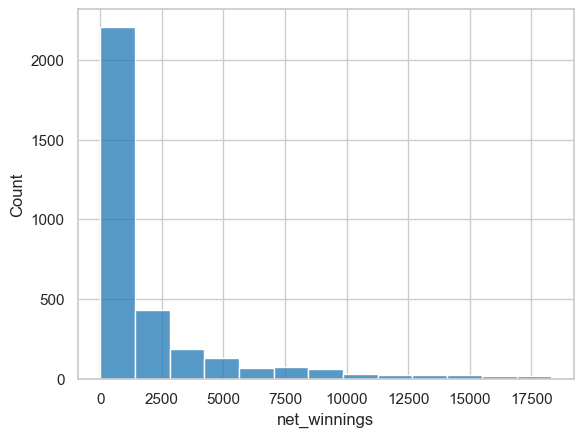

In [251]:
net_winnings_low = newDf['net_winnings'].quantile(0.01)
net_winnings_high = newDf['net_winnings'].quantile(0.99)

sns.histplot(data=newDf[(newDf['net_winnings'] > net_winnings_low) & (newDf['net_winnings'] < net_winnings_high)], x='net_winnings', bins="sturges")
plt.show()

In [252]:
X, y = df.drop(['churned'], axis=1), df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape)

(12669, 17) (5430, 17)


In [253]:
variables = df.columns.drop(['churned', 'winner']).tolist()
eqfd = EqualFrequencyDiscretiser(
  q=20,
  variables=variables,
  return_object=True
)

woe = MeanEncoder(variables=variables)

transformer = Pipeline(
  steps = [
    ('EqualFrequencyDiscretiser', eqfd),
    ('MeanEncoder', woe)
  ]
)

transformer.fit(X_train, y_train)

Pipeline(steps=[('EqualFrequencyDiscretiser',
                 EqualFrequencyDiscretiser(q=20, return_object=True,
                                           variables=['purchases_count',
                                                      'purchases_amount',
                                                      'cashouts_count',
                                                      'cashouts_amount',
                                                      'total_bets',
                                                      'winning_bets',
                                                      'losing_bets',
                                                      'total_risk', 'total_win',
                                                      'net_win', 'net_winnings',
                                                      'net_losses', 'win_ratio',
                                                      'risk_per_bet',
                                                      'net_winnings_per_bet',
                                                      'net_losses_per_bet'])),
                ('MeanEncoder',
                 MeanEncoder(variables=['purchases_count', 'purchases_amount',
                                        'cashouts_count', 'cashouts_amount',
                                        'total_bets', 'winning_bets',
                                        'losing_bets', 'total_risk',
                                        'total_win', 'net_win', 'net_winnings',
                                        'net_losses', 'win_ratio',
                                        'risk_per_bet', 'net_winnings_per_bet',
                                        'net_losses_per_bet']))])

In [254]:
transformer.named_steps['EqualFrequencyDiscretiser'].binner_dict_

{'purchases_count': [-inf, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0, 26.0, inf],
 'purchases_amount': [-inf,
  50.0,
  70.0,
  100.0,
  140.0,
  200.0,
  270.0,
  300.0,
  350.0,
  450.0,
  550.0,
  750.0,
  1000.0,
  1500.0,
  2288.4000000000087,
  4000.0,
  9830.399999999929,
  inf],
 'cashouts_count': [-inf, 1.0, 2.0, 4.0, inf],
 'cashouts_amount': [-inf,
  130.0,
  400.0,
  800.0,
  1500.0,
  3000.0,
  8868.39999999998,
  inf],
 'total_bets': [-inf,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  8.0,
  9.0,
  11.0,
  13.0,
  15.0,
  18.0,
  21.0,
  26.0,
  34.0,
  44.0,
  62.0,
  99.0,
  207.59999999999854,
  inf],
 'winning_bets': [-inf,
  1.0,
  2.0,
  3.0,
  4.0,
  6.0,
  7.0,
  10.0,
  14.0,
  23.0,
  51.0,
  inf],
 'losing_bets': [-inf,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  9.0,
  10.0,
  12.0,
  14.0,
  17.0,
  21.0,
  26.0,
  34.0,
  48.0,
  76.0,
  156.0,
  inf],
 'total_risk': [-inf,
  80.0,
  124.0,
  178.0,
  222.0,
  288.0,
  350.0,
  420.0,
  520.0,
  635.0,
  770.0,
  950.0,


In [255]:
transformer.named_steps['MeanEncoder'].encoder_dict_

{'purchases_count': {0: 0.9761512114677153,
  1: 0.9386834986474302,
  2: 0.9316770186335404,
  3: 0.9085510688836105,
  4: 0.8819599109131403,
  5: 0.8197674418604651,
  6: 0.7860696517412935,
  7: 0.5778491171749599},
 'purchases_amount': {0: 0.9915540540540541,
  1: 0.9844961240310077,
  2: 0.9860491071428571,
  3: 0.9912280701754386,
  4: 0.9762760603882099,
  5: 0.9566074950690335,
  6: 0.9790337283500455,
  7: 0.9775641025641025,
  8: 0.9688109161793372,
  9: 0.9577039274924471,
  10: 0.9694189602446484,
  11: 0.9215686274509803,
  12: 0.9093904448105437,
  13: 0.8438538205980066,
  14: 0.8262195121951219,
  15: 0.7463175122749591,
  16: 0.5946372239747634},
 'cashouts_count': {0: 0.9499353408461112,
  1: 0.9029126213592233,
  2: 0.8403041825095057,
  3: 0.6325503355704698},
 'cashouts_amount': {0: 0.9542225730071034,
  1: 0.9672619047619048,
  2: 0.9570957095709571,
  3: 0.9228395061728395,
  4: 0.8921095008051529,
  5: 0.8352180936995154,
  6: 0.6182965299684543},
 'total_bets'

In [256]:
train_t = transformer.transform(X_train)
test_t = transformer.transform(X_test)

test_t.head()

,purchases_count,purchases_amount,cashouts_count,cashouts_amount,total_bets,winning_bets,losing_bets,total_risk,total_win,net_win,net_winnings,net_losses,winner,win_ratio,risk_per_bet,net_winnings_per_bet,net_losses_per_bet
6818,0.98,0.98,0.95,0.95,0.95,0.96,0.94,0.98,0.98,0.97,0.94,0.97,0,0.91,0.97,0.93,0.95
24054,0.82,0.59,0.90,0.62,0.97,0.96,0.97,0.59,0.58,0.67,0.94,0.67,0,0.91,0.87,0.93,0.91
8390,0.98,0.98,0.95,0.95,0.95,0.92,0.94,0.99,0.98,0.97,0.94,0.97,0,0.92,0.97,0.93,0.94
16782,0.98,0.99,0.95,0.95,0.97,0.97,0.97,0.98,0.97,0.99,0.94,0.98,0,0.93,0.97,0.93,0.96
4395,0.98,0.99,0.95,0.95,0.96,0.97,0.97,0.99,0.98,0.98,0.94,0.98,0,0.93,0.98,0.93,0.95


In [257]:
print(train_t.shape, test_t.shape)

(12669, 17) (5430, 17)


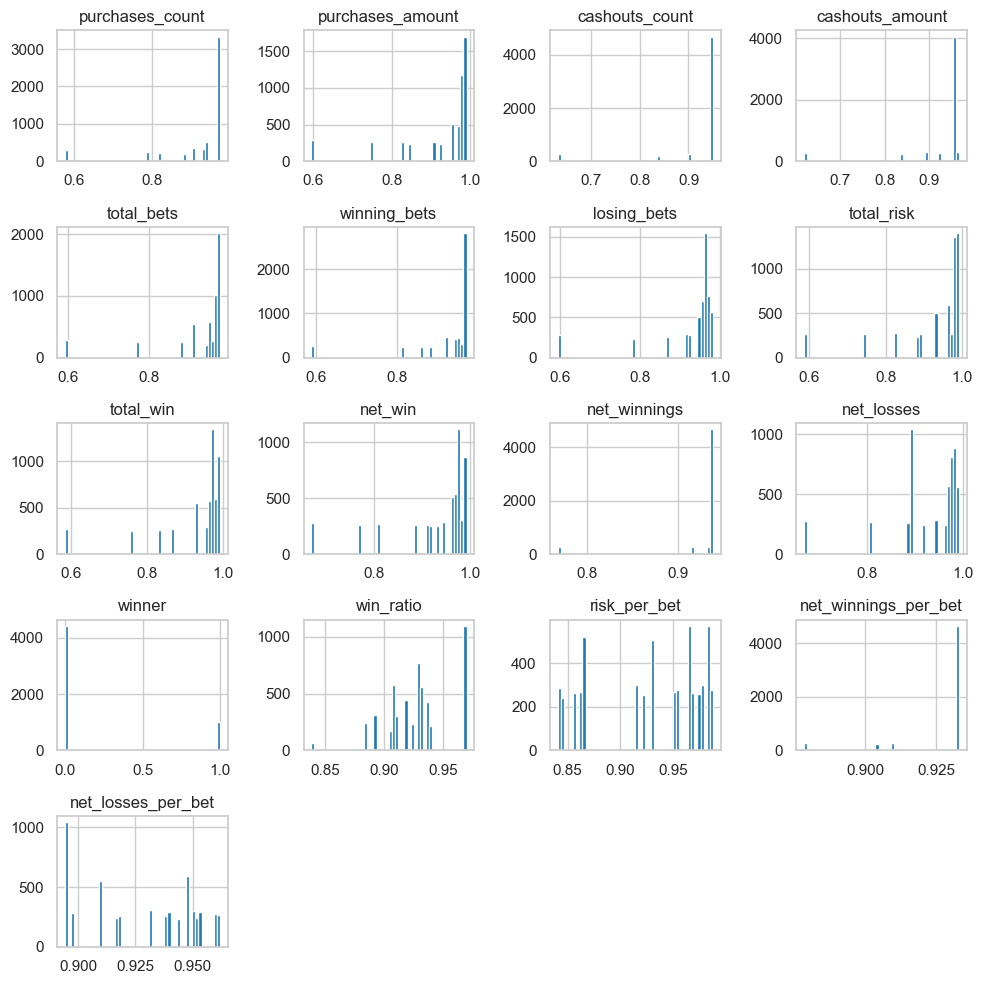

In [258]:
test_t.hist(bins=50, figsize=(10, 10))
plt.tight_layout()
plt.show()

In [259]:
train_t.columns

Index(['purchases_count', 'purchases_amount', 'cashouts_count',
       'cashouts_amount', 'total_bets', 'winning_bets', 'losing_bets',
       'total_risk', 'total_win', 'net_win', 'net_winnings', 'net_losses',
       'winner', 'win_ratio', 'risk_per_bet', 'net_winnings_per_bet',
       'net_losses_per_bet'],
      dtype='object')

In [260]:
# do a pca analysis to see if we can reduce the number of variables
from sklearn.decomposition import PCA

pca = PCA(svd_solver='full', n_components=0.95, random_state=42)
pca.fit(train_t)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# find the names of the variables that are most important in the first component
pcaDf = pd.DataFrame(pca.components_, columns=train_t.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
pcaEv = pd.DataFrame(pca.explained_variance_ratio_, columns=['explained_variance_ratio'], index=[f'PC{i+1}' for i in range(pca.n_components_)])




[0.65372409 0.23005441 0.04394076 0.01848229 0.01652841]
[45.32565868 26.88822657 11.75115839  7.62122576  7.20713134]


In [261]:
pcaDf.loc['PC1'].sort_values(ascending=False)

winner                  0.98
risk_per_bet           -0.01
win_ratio              -0.02
net_winnings_per_bet   -0.03
net_losses_per_bet     -0.04
purchases_count        -0.04
purchases_amount       -0.04
losing_bets            -0.04
total_bets             -0.05
winning_bets           -0.05
net_winnings           -0.05
net_losses             -0.05
total_risk             -0.06
cashouts_count         -0.06
net_win                -0.06
cashouts_amount        -0.09
total_win              -0.09
Name: PC1, dtype: float64

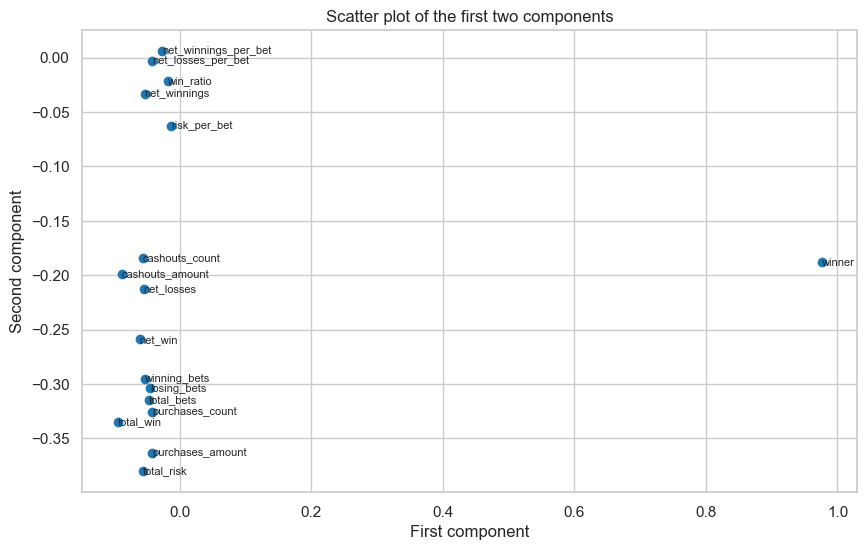

In [262]:
# scatter plot of the first two components
plt.figure(figsize=(10, 6))
plt.scatter(pcaDf.iloc[0], pcaDf.iloc[1])

for i, var in enumerate(pcaDf.columns):
    plt.text(pcaDf.iloc[0, i], pcaDf.iloc[1, i], var, fontsize=8, ha='left', va='center')


plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Scatter plot of the first two components')
plt.show()


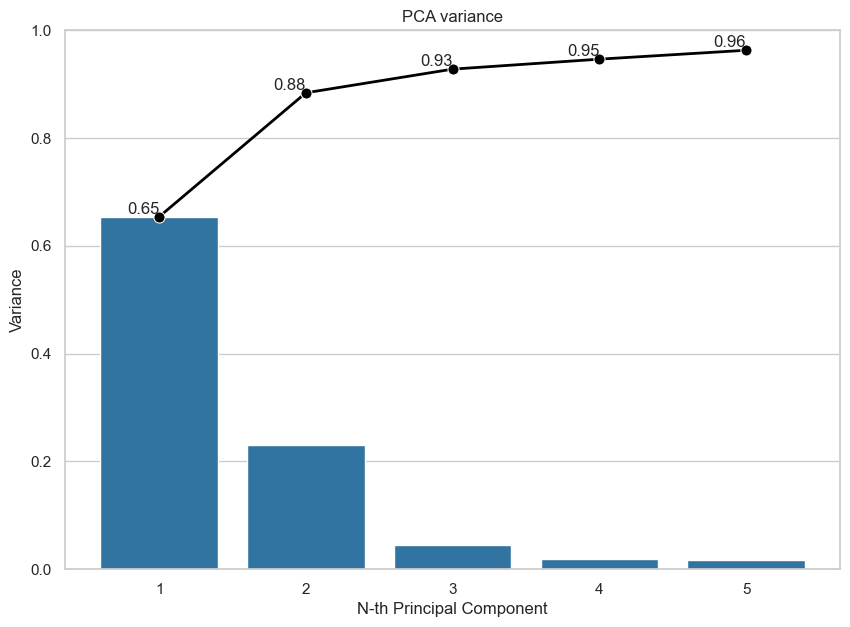

In [263]:
# plot the explained variance ratio with a scree plot
pc_components = np.arange(pca.n_components_) + 1

fig, ax = plt.subplots(figsize=(10,7))

cum_sum = np.cumsum(pca.explained_variance_ratio_)

_ = sns.barplot(x=pc_components, y=pca.explained_variance_ratio_)
_ = sns.lineplot(
  x=pc_components-1,
  y=cum_sum,
  color='black',
  linestyle='-',
  linewidth=2,
  marker='o',
  markersize=8
)
# anotate ticks for cumsum
for i in range(len(pca.explained_variance_ratio_)):
  ax.text(i, cum_sum[i], f'{cum_sum[i]:.2f}', ha='right', va='bottom')

plt.title('PCA variance')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance')
plt.ylim(0,1)
plt.show()

In [264]:
# https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

post_pca = pca.transform(train_t)
post_pcaDf = pd.DataFrame(post_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

In [265]:
n_pcs= pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = train_t.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

post_pcaDf.columns = most_important_names

['winner', 'total_risk', 'total_bets', 'cashouts_amount', 'purchases_count']


In [266]:
post_pcaDf.head()

,winner,total_risk,total_bets,cashouts_amount,purchases_count
0,0.77,-0.27,0.03,-0.06,-0.01
1,-0.21,-0.03,-0.03,0.01,0.02
2,-0.22,-0.11,-0.02,0.02,0.01
3,-0.22,-0.12,-0.03,0.02,-0.00
4,-0.17,0.15,0.21,-0.07,-0.14


In [267]:
post_pcaDf.describe().T

,count,mean,std,min,25%,50%,75%,max
winner,"12,669.00",0.00,0.40,-0.22,-0.22,-0.21,-0.12,0.98
total_risk,"12,669.00",-0.00,0.24,-0.30,-0.11,-0.09,0.02,1.07
total_bets,"12,669.00",0.00,0.10,-0.47,-0.04,-0.02,0.02,0.49
cashouts_amount,"12,669.00",-0.00,0.07,-0.35,-0.03,0.01,0.03,0.41
purchases_count,"12,669.00",0.00,0.06,-0.32,-0.02,0.00,0.01,0.43


Realizando una reducción de dimensionalidad con PCA para obtener el 95% de la varianza explicada, observamos que se necesitan 5 componentes principales.

Los resultados indican que las variables:
- winner
- total_risk
- total_bets
- cashouts_amount
- purchases_count

son las que más aportan a la varianza de los datos.

Sin embargo queremos explorar como otros comportamientos de los usuarios pueden estar relacionados con la variable target.

# Análisis PCA con pipeline de variables normalizadas

In [268]:
X, y = df.drop(['churned'], axis=1), df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(12669, 17) (5430, 17)


In [269]:
def apply_box_cox(X):
    """
    Apply box-cox transformation to all variables in the dataset
    X: numpy.ndarray
    """
    X = X.copy()
    for i in range(X.shape[1]):
        X[:, i] = boxcox(X[:, i] + 1)[0]
    return X


In [271]:
# columns_to_transform = df.columns.drop(['churned', 'winner', 'days_since_registration', 'net_win']).tolist()
columns_to_transform = df.columns.drop(['churned', 'winner', 'net_win']).tolist()
# other_columns = ['days_since_registration', 'net_win']
other_columns = ['net_win']


robust_pipe = Pipeline(
  steps = [
    ('RobustScaler', RobustScaler()),
    ('FunctionTransformer', FunctionTransformer(apply_box_cox))
  ]
)

power_transform_pipe = Pipeline(
  steps = [

    ('PowerTransformer', PowerTransformer())
  ]
)

preprocessor = ColumnTransformer(
  transformers = [
    ('robust_pipe', robust_pipe, columns_to_transform),
    # ('box_cox_pipe', box_cox_pipe, columns_to_transform),
    ('power_transform_pipe', power_transform_pipe, other_columns)
  ]
)

preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('robust_pipe',
                                 Pipeline(steps=[('RobustScaler',
                                                  RobustScaler()),
                                                 ('FunctionTransformer',
                                                  FunctionTransformer(func=<function apply_box_cox at 0x145602660>))]),
                                 ['purchases_count', 'purchases_amount',
                                  'cashouts_count', 'cashouts_amount',
                                  'total_bets', 'winning_bets', 'losing_bets',
                                  'total_risk', 'total_win', 'net_winnings',
                                  'net_losses', 'win_ratio', 'risk_per_bet',
                                  'net_winnings_per_bet',
                                  'net_losses_per_bet']),
                                ('power_transform_pipe',
                                 Pipeline(steps=[('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['net_win'])])

In [272]:
train_t = preprocessor.transform(X_train)
test_t = preprocessor.transform(X_test)

train_t = pd.DataFrame(train_t, columns=columns_to_transform + other_columns)
test_t = pd.DataFrame(test_t, columns=columns_to_transform + other_columns)

test_t.head()

,purchases_count,purchases_amount,cashouts_count,cashouts_amount,total_bets,winning_bets,losing_bets,total_risk,total_win,net_winnings,net_losses,win_ratio,risk_per_bet,net_winnings_per_bet,net_losses_per_bet,net_win
0,0.00,-0.13,0.00,0.00,0.33,0.25,0.38,-0.02,0.04,0.00,0.13,-0.24,-0.42,0.00,-0.20,0.00
1,0.77,0.93,0.44,0.74,0.03,0.25,0.00,0.97,0.86,0.00,1.10,0.43,1.37,0.00,1.21,-1.21
2,0.00,-0.20,0.00,0.00,0.42,0.59,0.38,-0.11,-0.02,0.00,0.01,0.50,-0.68,0.00,-0.36,0.00
3,-0.50,-0.39,0.00,0.00,-0.31,-0.20,-0.29,-0.34,-0.19,0.00,-0.12,-0.14,-0.36,0.00,0.16,0.00
4,-0.50,-0.29,0.00,0.00,-0.44,-0.20,-0.45,-0.34,-0.18,0.00,-0.17,0.27,-0.15,0.00,0.28,0.00


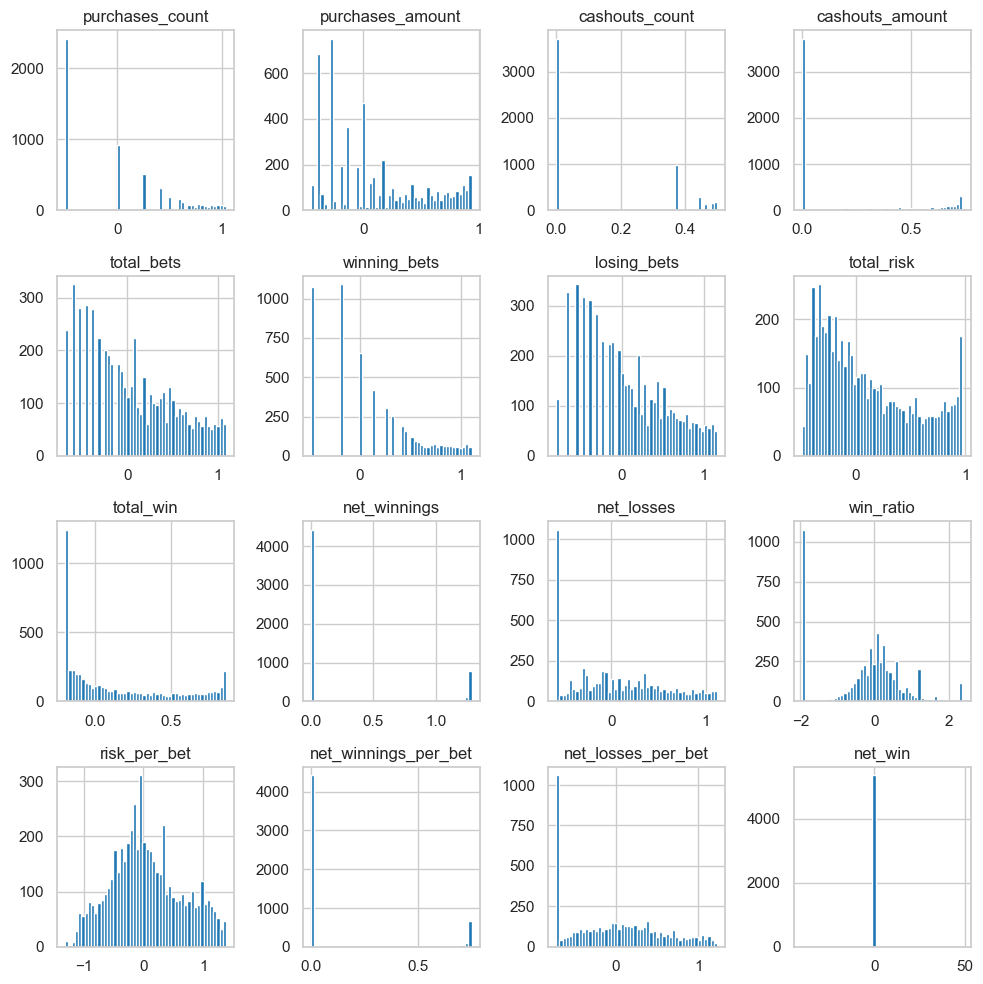

In [273]:
test_t.hist(bins=50, figsize=(10, 10))
plt.tight_layout()
plt.show()

In [274]:
pca = PCA(svd_solver='full', n_components=0.95, random_state=42)
pca.fit(train_t)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# find the names of the variables that are most important in the first component
pcaDf = pd.DataFrame(pca.components_, columns=train_t.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
pcaEv = pd.DataFrame(pca.explained_variance_ratio_, columns=['explained_variance_ratio'], index=[f'PC{i+1}' for i in range(pca.n_components_)])


[0.32849347 0.22243992 0.19070701 0.11491432 0.08558936 0.021965  ]
[145.18182563 119.46900423 110.61963302  85.86891057  74.1069231
  37.54174654]


In [275]:
pcaDf.loc['PC1'].sort_values(ascending=False)

win_ratio               0.75
winning_bets            0.29
net_winnings            0.24
total_bets              0.21
total_win               0.19
losing_bets             0.17
total_risk              0.14
net_winnings_per_bet    0.14
cashouts_amount         0.12
purchases_count         0.12
cashouts_count          0.08
purchases_amount        0.07
net_win                 0.07
risk_per_bet           -0.02
net_losses             -0.10
net_losses_per_bet     -0.30
Name: PC1, dtype: float64

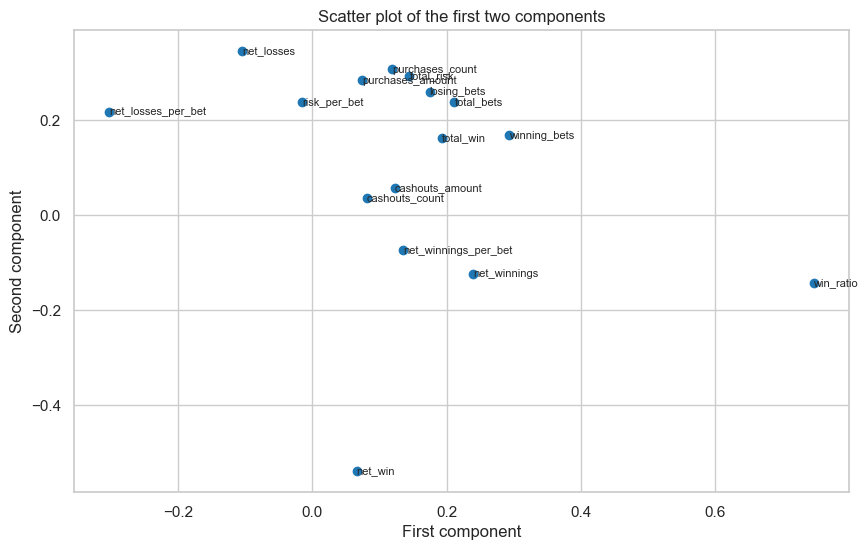

In [276]:
# scatter plot of the first two components
plt.figure(figsize=(10, 6))
plt.scatter(pcaDf.iloc[0], pcaDf.iloc[1])

for i, var in enumerate(pcaDf.columns):
    plt.text(pcaDf.iloc[0, i], pcaDf.iloc[1, i], var, fontsize=8, ha='left', va='center')


plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Scatter plot of the first two components')
plt.show()

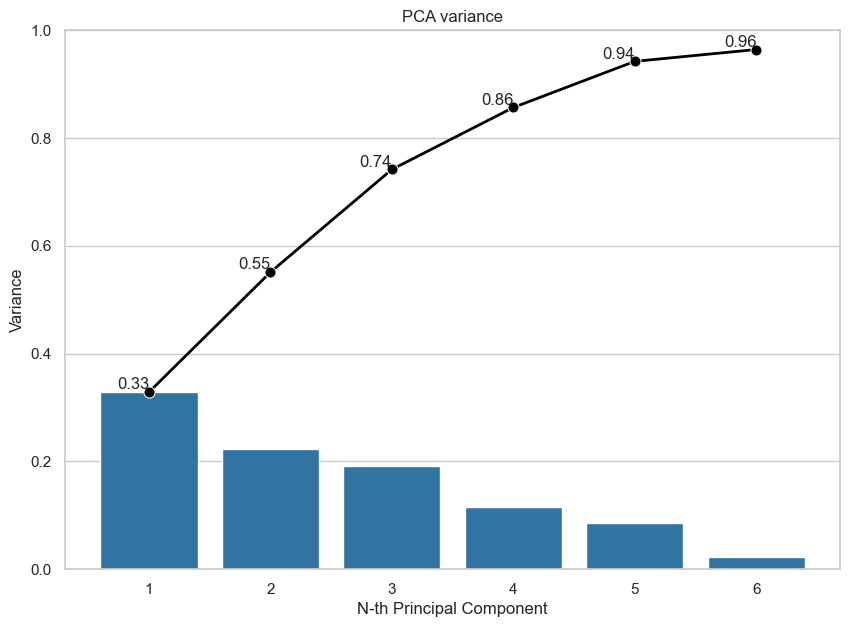

In [277]:
# plot the explained variance ratio with a scree plot
pc_components = np.arange(pca.n_components_) + 1

fig, ax = plt.subplots(figsize=(10,7))

cum_sum = np.cumsum(pca.explained_variance_ratio_)

_ = sns.barplot(x=pc_components, y=pca.explained_variance_ratio_)
_ = sns.lineplot(
  x=pc_components-1,
  y=cum_sum,
  color='black',
  linestyle='-',
  linewidth=2,
  marker='o',
  markersize=8
)
# anotate ticks for cumsum
for i in range(len(pca.explained_variance_ratio_)):
  ax.text(i, cum_sum[i], f'{cum_sum[i]:.2f}', ha='right', va='bottom')

plt.title('PCA variance')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance')
plt.ylim(0,1)
plt.show()

In [278]:
# https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

post_pca = pca.transform(train_t)
post_pcaDf = pd.DataFrame(post_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

In [279]:
n_pcs= pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = train_t.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

post_pcaDf.columns = most_important_names

['win_ratio', 'net_win', 'net_win', 'risk_per_bet', 'net_winnings', 'purchases_count']


In [280]:
post_pcaDf.head()

,win_ratio,net_win,net_win,risk_per_bet,net_winnings,purchases_count
0,1.67,-1.21,0.91,-1.26,0.84,0.02
1,0.73,0.39,-0.10,0.10,-0.61,0.00
2,-0.15,-0.57,0.51,-0.36,-0.61,0.16
3,-0.53,-0.92,0.59,0.32,-0.37,0.00
4,-0.85,1.33,-0.69,-1.09,-0.15,-0.55


In [281]:
post_pcaDf.describe().T

,count,mean,std,min,25%,50%,75%,max
win_ratio,"12,669.00",0.00,1.29,-2.74,-0.66,0.13,0.93,4.45
net_win,"12,669.00",-0.00,1.06,-19.16,-0.65,-0.11,0.55,38.64
net_win,"12,669.00",0.00,0.98,-31.52,-0.39,0.02,0.39,53.81
risk_per_bet,"12,669.00",-0.00,0.76,-2.62,-0.48,0.06,0.54,5.10
net_winnings,"12,669.00",-0.00,0.66,-4.27,-0.50,-0.24,0.46,9.19
purchases_count,"12,669.00",-0.00,0.33,-1.22,-0.24,-0.02,0.20,1.53


En el análisis de PCA con pipeline de variables normalizadas observamos que se necesitan 7 componentes principales para obtener el 95% de la varianza explicada.

Lo cual nos indica que podemos mantener mas variables en el modelo que impacten en la varianza de los datos reteniendo el comportamiento de los usuarios.


# Conclusiones y justificación del proceso

## Construcción

En la construcción de variables y feature engeeniering, regresamos a la base de datos original con los datos originales que se extraen directamente de la base de datos, ya que en la presentación de datos original se presentaron con variables calculadas a partir de las variables originales.

Esto con el fin de mostrar de manera más clara el proceso de ingeniería de características.

Resumiendo, se generaron las siguientes características:

- net_winnings
- net_losses
- winner (variable categórica)

Relaciones entre variables existentes:

- win_ratio
- risk_per_bet
- net_winnings_per_bet
- net_losses_per_bet


## Normalización y Binning

En nuestro análisis de datos, notamos que hay variables que están dominadas por valores como 0, como es el caso de cashouts_count y cashouts_amount.

Se deicidio el no omitir outliers ya que en el análisis de la eliminación de valores atípicos se observó que se pierde información de la clase minoritaria.

Se decidió realizar una discretización de las variables para poder manejar los valores atípicos y la distribución asimétrica de las características, se utilizó un método de discretización en 20 bins utilizando EqualFrequencyDiscretiser que discretiza las variables en intervalos de igual frecuencia.


También se realizaron transformaciones de datos que pudieran quitar el sesgo de las variables.

Para las variables 
**['purchases_count', 'purchases_amount', 'cashouts_count', 'cashouts_amount', 'total_bets', 'winning_bets', 'losing_bets', 'total_risk', 'total_win', 'net_winnings', 'net_losses', 'win_ratio', 'risk_per_bet', 'net_winnings_per_bet', 'net_losses_per_bet']**

Se aplico un robust scaler seguido de una transformación box-cox para quitar el sesgo de las variables.

Para las variables 
**['net_win']**

Únicamente se aplicó un PowerTransformer para quitar el sesgo de las variables.

No se realizó el proceso similar ya que al aplicar el RobustScaler tenemos valores negativos y no se puede aplicar la transformación box-cox.


## Selección de características

Se realizo análisis de PCA para obtener el 95% de la varianza explicada con los dos tipos de transformaciones de datos.

Se observo que se necesitan 5 componentes principales para obtener el 95% de la varianza explicada en el análisis de PCA con los datos que se transformaron en Bins.

Se observo que se necesitan 7 componentes principales para obtener el 95% de la varianza explicada en el análisis de PCA con los datos que se transformaron con un pipeline de variables normalizadas.

Se elige PCA ya que es una técnica comúnmente utilizada en el ámbito de ciencia de datos y machine learning para reducir la dimensionalidad de los datos y para poder visualizar los datos en un espacio de menor dimensión.

Ayuda también a la reducción de ruido y a la eliminación de la multicolinealidad y es computacionalmente eficiente.

## Conclusiones

En este ejercicio de ingeniería de características pudimos observar que tenemos unas distribuciones de datos sumamente asimétricas y con muchos valores atípicos.

Las transformaciones de datos y la discretización de variables nos pueden ayudar con los sesgos de variables y los valores atípicos.

Una alternativa que falta explorar sería el crear un pipeline de transformación de datos y binning donde podamos realizar otro análisis de reducción de dimensionalidad obteniendo mejores resultados.
